https://www.aprendemachinelearning.com/clasificacion-de-imagenes-en-python/

https://towardsdatascience.com/image-generation-in-10-minutes-with-generative-adversarial-networks-c2afc56bfa3b

machine learning generate images based on text

la idea del baseline es tener un modelo choto, para que cuando lo mejore tenga algo para comparar.

es hacer algo muy rápido y barato de hacer. La idea es minimizar el esfuerzo

* batchsize, ponerlo lo más grande posible
* que es dropout 
* que es el early stoping (usar siempre) redes neuronales


## Importacion y dataframe

###Drive

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.ticker
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#procesar imagenes
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, drive
from oauth2client.client import GoogleCredentials

drive.mount('/content/gdrive')

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


https://towardsdatascience.com/how-to-successfully-add-large-data-sets-to-google-drive-130beb320f1a


In [ ]:
#@title zip y unzip
# !unzip "/content/gdrive/MyDrive/Organización de Datos/TPS/TP4/Datos/silkroad2_images.zip" -d "/content/gdrive/MyDrive/Organización de Datos/TPS/TP4/Datos"

#-d creates the directory and extracted files are stored there.



# direccion = "Organización de Datos/TPS/TP4/Datos/"
# !unzip ("/content/gdrive/MyDrive/"+direccion+"/test 9 imagenes.zip") -d ("/content/gdrive/MyDrive/"+direccion+"/unziped")
#https://colab.research.google.com/github/sudo-ken/compress-decompress-in-Google-Drive/blob/master/Unrar_Unzip_Rar_Zip_in_GDrive.ipynb#scrollTo=VKdYIG49VaYA



# from zipfile import ZipFile
# with ZipFile("/content/gdrive/MyDrive/Organización de Datos/TPS/TP4/Datos/test 9 imagenes.zip", "r") as archivo:
#   archivo.extractall("/content/gdrive/MyDrive/Organización de Datos/TPS/TP4/Datos/unziped")

#https://www.kaggle.com/mchirico/how-to-read-datasets

In [ ]:
downloaded = drive.CreateFile({'id': '1FYEJ8QxvNzDF55EfE9gy_pMEmHftky4_'})
downloaded.GetContentFile('silkroad_items.csv')

items=pd.read_csv('silkroad_items.csv')

In [ ]:
# # modelos
# from sklearn import model_selection
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier

# # metricas
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, mean_squared_error
# from sklearn.model_selection import cross_val_score

# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import GridSearchCV

# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import KFold
# from sklearn.model_selection import train_test_split
# from scipy.stats import loguniform

In [ ]:
# kaggle_tests = pd.merge(test_identity, test_transaction, left_on='TransactionID', right_on='TransactionID', how='outer')

###Dataframe

In [ ]:
direccion_imagenes = "/content/gdrive/MyDrive/Organización de Datos/TPS/TP4/Datos/unziped/images_by_id/"

In [ ]:
# with Image.open(direccion_imagenes+'/108.jpg') as im:
#     im.rotate(45).show()

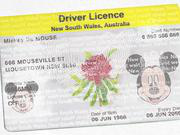

In [ ]:
img = load_img(direccion_imagenes+'/108.jpg')
img

#imagenes de 180x135
# https://gianmarco.com.ar/blog/es/blog/silkroad2

####de numpy a imagen y viseversa

https://stackoverflow.com/questions/384759/how-to-convert-a-pil-image-into-a-numpy-array

In [ ]:
def pilToNumpy(img):
    return np.array(img)   # im2arr.shape: height x width x channel

def NumpyToPil(img):
    return Image.fromarray(img)

In [ ]:
im = Image.open(direccion_imagenes+'/108.jpg')
testImage = pilToNumpy(im)

In [ ]:
testImage[0]

In [ ]:
len(pilToNumpy(im))

135

##analisis exploratorio

https://gianmarco.com.ar/blog/es/blog/silkroad2

In [ ]:
#solo conservar items que tengan una imagen asociada
items = items[items['image_id'].notnull()]

In [ ]:
items.head()

,item_id,title,description,vendor,price,category,timestamp,ships_from,ships_to,image_id,original_path
1,the-morality-of-capitalism,The Morality of Capitalism,\n This book has been made available to the...,echo,0.003443,Alcohol,2014-02-23T05:39:29,Undeclared,Undeclared,343.0,2014-02-24/items/the-morality-of-capitalism
2,survive,Survive!,"\n Since the dawn of time, when man first p...",echo,0.001722,Alcohol,2014-02-23T05:39:33,Undeclared,Undeclared,334.0,2014-02-24/items/survive
3,a-non-religious-new-testament,A Non-Religious New Testament,\n This is essentially the Bible written in...,echo,0.015496,Alcohol,2014-02-23T05:39:37,Undeclared,Undeclared,352.0,2014-02-24/items/a-non-religious-new-testament
4,mindless-slogans-101-cheap-substitutes-for-act...,Mindless Slogans: 101 Cheap Substitutes for Ac...,\n Think of all the stupid stuff you overhe...,echo,0.001722,Alcohol,2014-02-23T05:39:41,Undeclared,Undeclared,337.0,2014-02-24/items/mindless-slogans-101-cheap-su...
6,god-wants-you-dead,God Wants You Dead,\n FANTASTIC book for social and cultural d...,echo,0.001722,Drugs,2014-02-23T05:39:48,Undeclared,Undeclared,293.0,2014-02-24/items/god-wants-you-dead


####Primer idea. En base a descripciones generar una imagen

In [ ]:
items[items["description"].str.contains("book", na=False, case=False)].head(3)

,item_id,title,description,vendor,price,category,timestamp,ships_from,ships_to,image_id,original_path
1,the-morality-of-capitalism,The Morality of Capitalism,\n This book has been made available to the...,echo,0.003443,Alcohol,2014-02-23T05:39:29,Undeclared,Undeclared,343.0,2014-02-24/items/the-morality-of-capitalism
2,survive,Survive!,"\n Since the dawn of time, when man first p...",echo,0.001722,Alcohol,2014-02-23T05:39:33,Undeclared,Undeclared,334.0,2014-02-24/items/survive
4,mindless-slogans-101-cheap-substitutes-for-act...,Mindless Slogans: 101 Cheap Substitutes for Ac...,\n Think of all the stupid stuff you overhe...,echo,0.001722,Alcohol,2014-02-23T05:39:41,Undeclared,Undeclared,337.0,2014-02-24/items/mindless-slogans-101-cheap-su...


hay muchos articulos que en realidad son libros pero que tienen la categoría de alcohol. por lo tanto conviene no usar la categoría para generar las imagenes. 
* en la explicación del dataset dice que solo se pudo obtener la primer categoría del item, pero no la subcategoría más específica

como las categorias son una porquería trato de filtar los datos para generar imagenes de drogas unicamente

In [ ]:
items[(items["category"]=="Drugs") & (items["description"].str.contains("book", na=False, case=False) == False)].head()

,item_id,title,description,vendor,price,category,timestamp,ships_from,ships_to,image_id,original_path
301,bulk-research-chemicals,BULK RESEARCH CHEMICALS,\n Read my vendor profile and contact me to...,TheScienceGuy,0.000000,Drugs,2014-02-23T08:37:40,China,Worldwide,2451.0,2014-02-24/items/bulk-research-chemicals
302,custom-listing-for-mc,Custom Listing for MC,\n 25g 2c-t-2 and 50g methylone for $750 (n...,TheScienceGuy,1.277828,Drugs,2014-02-23T08:37:43,China,Worldwide,3242.0,2014-02-24/items/custom-listing-for-mc
366,do-you-have-bitcoins-to-sell,Do you have BITCOINS to SELL?,"\n I will buy your bitcoins, CASH!\nIf you ...",BTCpal,0.000000,Drugs,2014-02-23T10:00:29,Undeclared,Undeclared,3392.0,2014-02-24/items/do-you-have-bitcoins-to-sell
991,50-grams-of-ketamine,50 grams of Ketamine,\n 50 grams of my fine 98%+ pure Indian sha...,haydenp,3.005410,Drugs,2014-02-23T14:44:24,United States,United States,3918.0,2014-02-24/items/50-grams-of-ketamine
992,one-ounce-28-3-grams-of-ketamine-haydenp,One ounce (28.3 grams) of Ketamine,\n 28.3 grams of my fine 98%+ pure Indian s...,haydenp,1.786721,Drugs,2014-02-23T14:44:40,United States,United States,3917.0,2014-02-24/items/one-ounce-28-3-grams-of-ketam...


aún asi es dificl de comparar con la imagen

In [ ]:
with pd.option_context('display.max_colwidth', None):
  display(items[(items["category"]=="Drugs") & (items["description"].str.contains("book", na=False, case=False) == False)][["description", "image_id"]].iloc[115:116,:])

,description,image_id
7521,"\n 1 tablet of 10MG METHADONE (Methadone Hydrochloride) manufactured by Roxane Laboratories, Inc.\n\nMinimum $50 USD per shipment, you may order as many different items you like from my shop. Please select and pay for a shipment option, then select ADD TO OTHER SHIPMENT on the rest.\n",6715.0


####Segunda idea. A partir de una sola palabra

In [ ]:
#en base al titulo
# items[(len(items["title"]) < 30)].iloc[30:50,:]

# items[items['title'].str.findall('\w{9,}').str.join(' ').astype(bool)]      #mayores a 9 caracteres

# items[items["title"].str.findall("(\S{4,})").astype(bool)]    #palabras?

In [ ]:
#en base a la categoría
# items[(len(items["title"]) == 1)].iloc[30:50,:]

###cuantas categorías hay?

In [ ]:
items.nunique().to_frame().T
# https://www.geeksforgeeks.org/how-to-count-distinct-values-of-a-pandas-dataframe-column/

# df.select_dtypes(exclude = ['number'])

,item_id,title,description,vendor,price,category,timestamp,ships_from,ships_to,image_id,original_path
0,32379,30263,33802,1281,237817,301,242864,59,28,32539,367673


In [ ]:
#cantidad de cada categoría
items["category"].value_counts().to_frame().T

,Alcohol,Stimulants,Weed,Ecstasy,MDMA,Cannabis,Cocaine,LSD,Speed,Drug paraphernalia,Steroids/PEDs,Other,Analgesics,Anabolic Steroids,NBOMe,Benzos,Heroin,Alprazolam,Dissociatives,Drugs,Concentrates,Forgeries,2C-Family,Diazepam,DMT,Oxycodone,Opioids,Digital goods,Sildenafil Citrate,Prescription,Edibles,Shrooms,Books,Apparel,Psychedelics,Chemicals,Relaxants,Pills,Methylphenidate,Tadalafil,...,Budder,Herbal Viagra,Freebase,Herbs & Supplements,Candy,25N-NBOMe,Suboxone,Mesterolone,Prozac,Azurescens,2-DPMP,Liberty Caps,Cyanescens,DPT,Superdrol,Snovitra,Strattera,2C-B-FLY,Dioscorea,Clones,Supplements,Stendra,Aleph-2,Anti-inflammatory,5-MeO-DipT,Tilidine,4-ACO-MIPT,4-HO-MPT,Pethidine,Anti-rheumatic,Topicals,Co-codamol,Cultures,AMT,Opana,MET,4-HO-MET,Peyote,2C-D,2C-T-4
category,71133,24372,19587,17947,16013,14496,13036,10776,8622,7776,7428,6676,6239,5933,5911,5655,5273,5265,4850,4791,4413,4059,3856,3626,3539,3402,3267,3257,3256,3254,3110,2863,2840,2474,2411,2214,1752,1748,1641,1462,...,7,7,7,7,7,7,6,6,6,5,5,5,5,5,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,2,2,2,1,1,1,1,1


####cosas interesantes/divertidas del dataset

In [ ]:
items[items["ships_to"]=="Argentina"]

,item_id,title,description,vendor,price,category,timestamp,ships_from,ships_to,image_id,original_path
242354,modem,modem,\n get em here\n,pentest002,0.105,Alcohol,2014-09-15T03:40:32,Austria,Argentina,48451.0,2014-09-15/items/modem


###encondings

####MeanEncoding

hecho como $\frac{Fraude}{(Fraude+NoFraude)}$

https://www.geeksforgeeks.org/mean-encoding-machine-learning/


In [ ]:
#no modifica el df original

def meanEncoding(dataframe, nombreColumnas):
  temp = dataframe
  for i in nombreColumnas:
    Mean_encoded_subject = dataframe.groupby(i)['isFraud'].mean().to_dict()
    temp[i] =  dataframe[i].map(Mean_encoded_subject)
  return temp

#ejemplo -> df.groupby(['ProductCD'])['isFraud'].mean()

####OneHotEncoding

https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python

In [ ]:
#no modifica el df original

def oneHotEncoding(df_original, columna):
    dummies = pd.get_dummies(df_original[[columna]])
    res = pd.concat([df_original, dummies], axis=1)
    res = res.drop([columna], axis=1)
    return(res)

####countEncoding

In [ ]:
# train.groupby(['ProductCD'])['isFraud'].count()

https://towardsdatascience.com/guide-to-encoding-categorical-features-using-scikit-learn-for-machine-learning-5048997a5c79


https://pbpython.com/categorical-encoding.html

##GAN


####explicacion

![image](https://miro.medium.com/max/700/1*i4HTOtqH4qt9zIZUN43GoA.png)

el generador lo que hace es

![image.png](https://www.tensorflow.org/tutorials/generative/images/gan2.png)

###base line, en blanco y negro

https://towardsdatascience.com/image-generation-in-10-minutes-with-generative-adversarial-networks-c2afc56bfa3b

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)
import matplotlib.pyplot as plt

In [ ]:
# underscore to omit the label arrays
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() 
train_labels[3654] = 12.23


train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() 

# len(train_images[0][0])
train_images.shape

(60000, 28, 28)

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [ ]:
generator = make_generator_model()

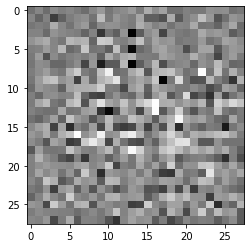

In [ ]:
# Create a random noise and generate a sample
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
# Visualize the generated sample
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()


In [ ]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00019265]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 1
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
num_examples_to_generate = 16
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# tf.function annotation causes the function 
# to be "compiled" as part of the training
@tf.function
def train_step(images):
  
    # 1 - Create a random noise to feed it into the model
    # for the image generation
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # 2 - Generate images and calculate loss values
    # GradientTape method records operations for automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # 3 - Calculate gradients using loss values and model variables
    # "gradient" method computes the gradient using 
    # operations recorded in context of this tape (gen_tape and disc_tape).
    
    # It accepts a target (e.g., gen_loss) variable and 
    # a source variable (e.g.,generator.trainable_variables)
    # target --> a list or nested structure of Tensors or Variables to be differentiated.
    # source --> a list or nested structure of Tensors or Variables.
    # target will be differentiated against elements in sources.

    # "gradient" method returns a list or nested structure of Tensors  
    # (or IndexedSlices, or None), one for each element in sources. 
    # Returned structure is the same as the structure of sources.
    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                discriminator.trainable_variables)
    
    # 4 - Process  Gradients and Run the Optimizer
    # "apply_gradients" method processes aggregated gradients. 
    # ex: optimizer.apply_gradients(zip(grads, vars))
    """
    Example use of apply_gradients:
    grads = tape.gradient(loss, vars)
    grads = tf.distribute.get_replica_context().all_reduce('sum', grads)
    # Processing aggregated gradients.
    optimizer.apply_gradients(zip(grads, vars), experimental_aggregate_gradients=False)
    """
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
import time
from IPython import display # A command shell for interactive computing in Python.

def train(dataset, epochs):
  # A. For each epoch, do the following:
  for epoch in range(epochs):
    start = time.time()
    # 1 - For each batch of the epoch, 
    for image_batch in dataset:
      # 1.a - run the custom "train_step" function
      # we just declared above
      train_step(image_batch)

    # 2 - Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 3 - Save the model every 5 epochs as 
    # a checkpoint, which we will use later
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # 4 - Print out the completed epoch no. and the time spent
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # B. Generate a final image after the training is completed
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  # 1 - Generate images
  predictions = model(test_input, training=False)
  # 2 - Plot the generated images
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  # 3 - Save the generated images
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


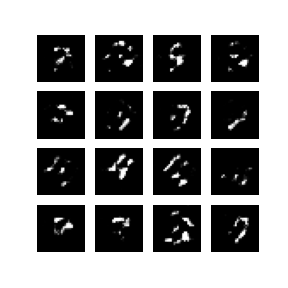

In [ ]:
# PIL is a library which may open different image file formats
import PIL 
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(EPOCHS)

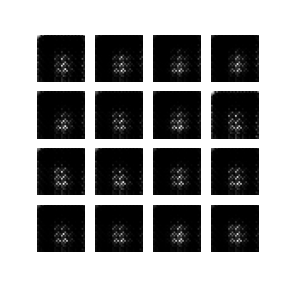

In [ ]:
import glob # The glob module is used for Unix style pathname pattern expansion.
import imageio # The library that provides an easy interface to read and write a wide range of image data

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  # image = imageio.imread(filename)
  # writer.append_data(image)
  
display.Image(open('dcgan.gif','rb').read())

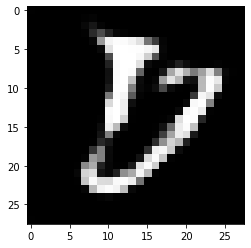

In [ ]:
# Create a random noise and generate a sample
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
# Visualize the generated sample
plt.imshow(generated_image[0, :, :, 0], cmap='gray')